## Time Series Analysis with Machine Learning

#### Part I: Statitionary Time Series
Time series (TS) is a collection of data points collected at different recording (time) intervals<br>
These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis

How this forecast is different than a regression problem ?
* It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold
* Along with an increasing or decreasing trend, most TS have some form of seasonality trends

In [66]:
from dateutil.parser import parse 
import matplotlib as mpl
from matplotlib.pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf


from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
# from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
ts = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month')
ts.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Number of Air Passengers')

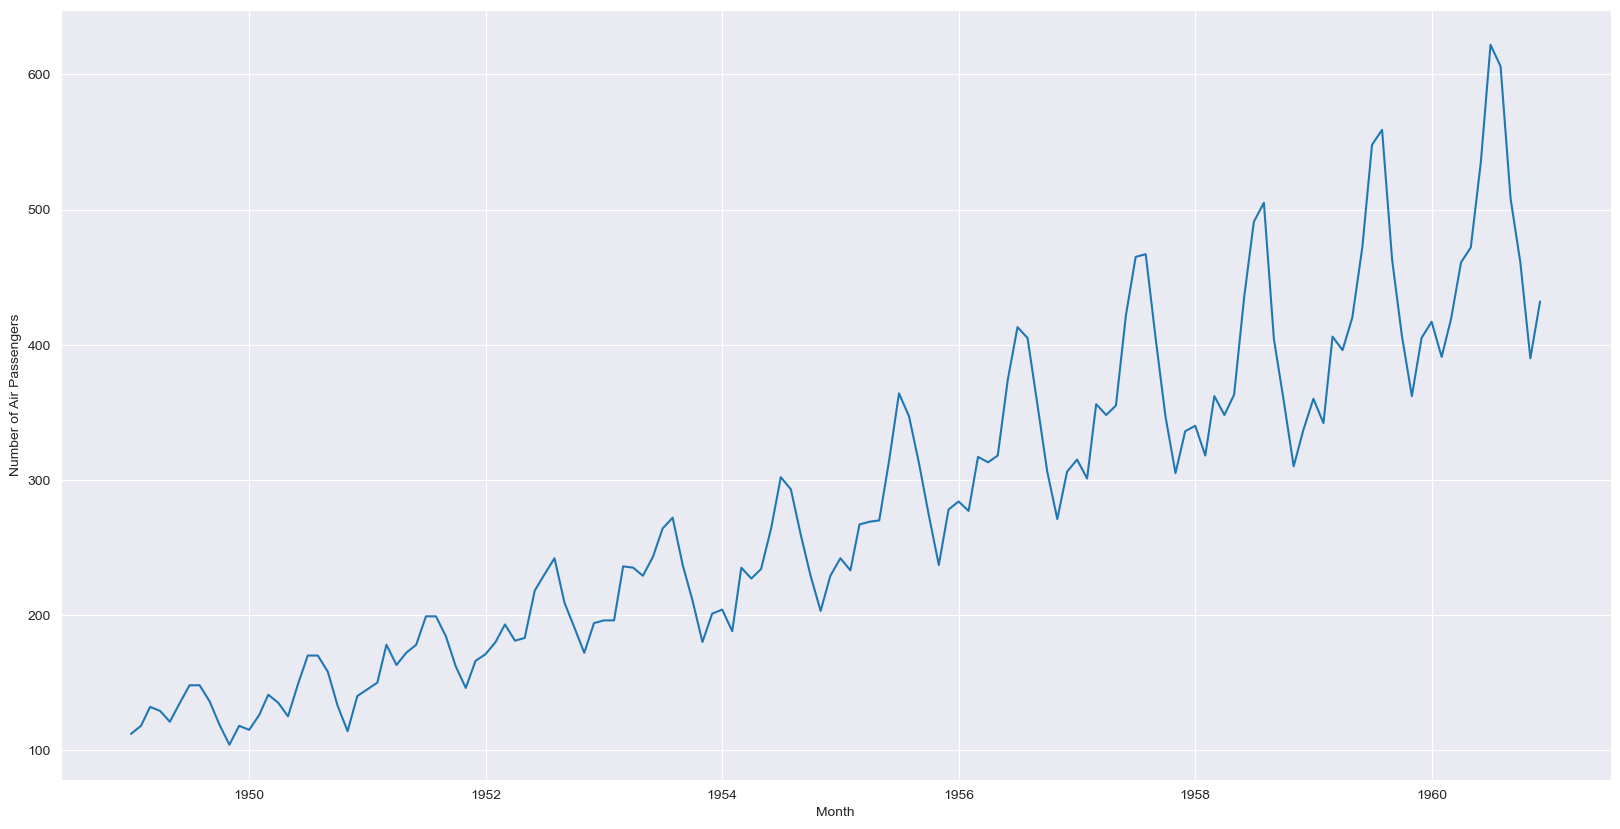

In [3]:
plt.figure(figsize=(20,10))
plt.plot(ts)
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")

* As we know that, A stationary Time Series is one which characteristics like mean and variance does not change over time
* Preparing the data for analyzing the Rolling Mean and Standard Deviation to check stationarity for given Time Series

In [6]:
rolmean = ts.rolling(window=12).mean()
rolstd = ts.rolling(window=12).std()
print(rolmean.head(15).dropna()) # first 12 values are nan
print(rolstd.head(15).dropna())

            #Passengers
Month                  
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
            #Passengers
Month                  
1949-12-01    13.720147
1950-01-01    13.453342
1950-02-01    13.166475
1950-03-01    13.686977


Plotting the Rolling Mean and Standard Deviation, which has window of 12, we conclude that, it is non-stationary because mean and variance is not constant

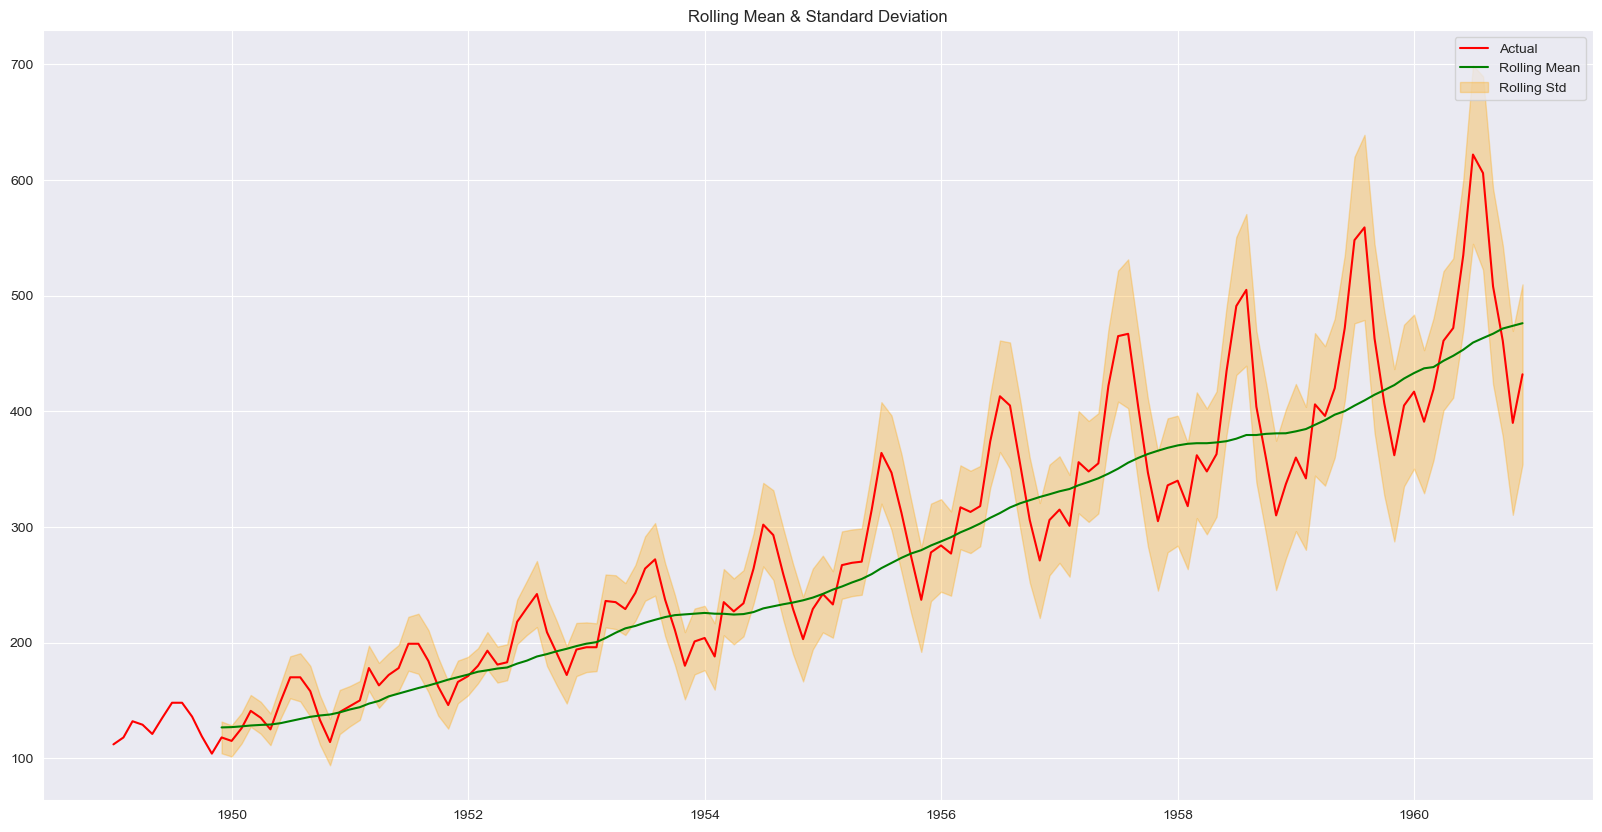

In [43]:
# plot the series
ts_pass = np.array(ts["#Passengers"])
plt.figure(figsize=(20,10))
actual = plt.plot(ts, color='red', label='Actual')
mean_12 = plt.plot(rolmean, color='green', label='Rolling Mean')
std_12 = plt.fill_between(ts.index,
                          ts_pass - np.array(rolstd).reshape((144,)),
                          ts_pass + np.array(rolstd).reshape((144,)),
                          alpha = 0.3, color='orange', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

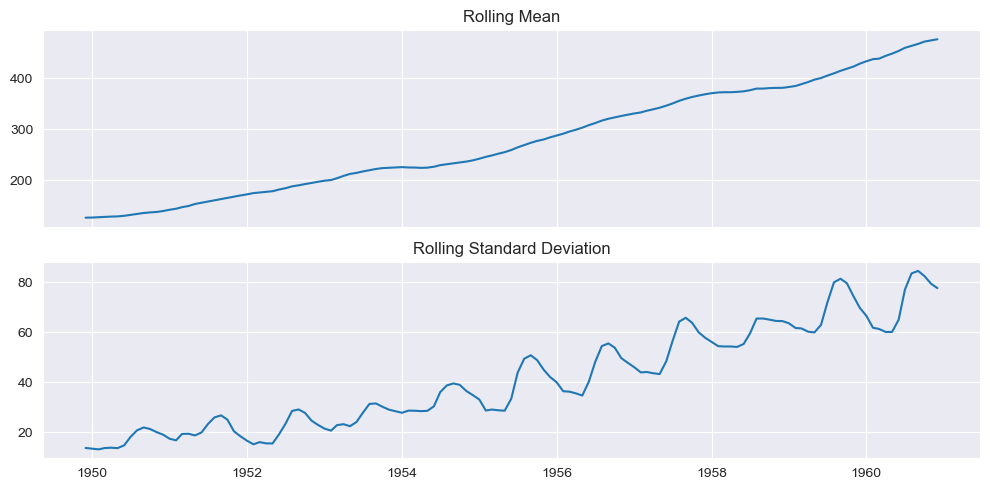

In [44]:
# visualize stationarity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5), sharex=True)
ax1.plot(rolmean)
ax1.set_title("Rolling Mean")
ax2.plot(rolstd)
ax2.set_title("Rolling Standard Deviation")
plt.tight_layout()

* Another way of checking for stationarity of the time seris is using **Augmented Dickey-Fuller (ADF)** Test to check stationarity.
* ADF has : Null hypothesis - Time Series is non-stationary

In [45]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


* From above ADF test, we fail to reject the null hypothesis, since p-value is greater than 0.05

### Log transform

To remove the non-stationarity of the time series, we can apply first **log transform** as below first and then plot rolling average and standard deviation

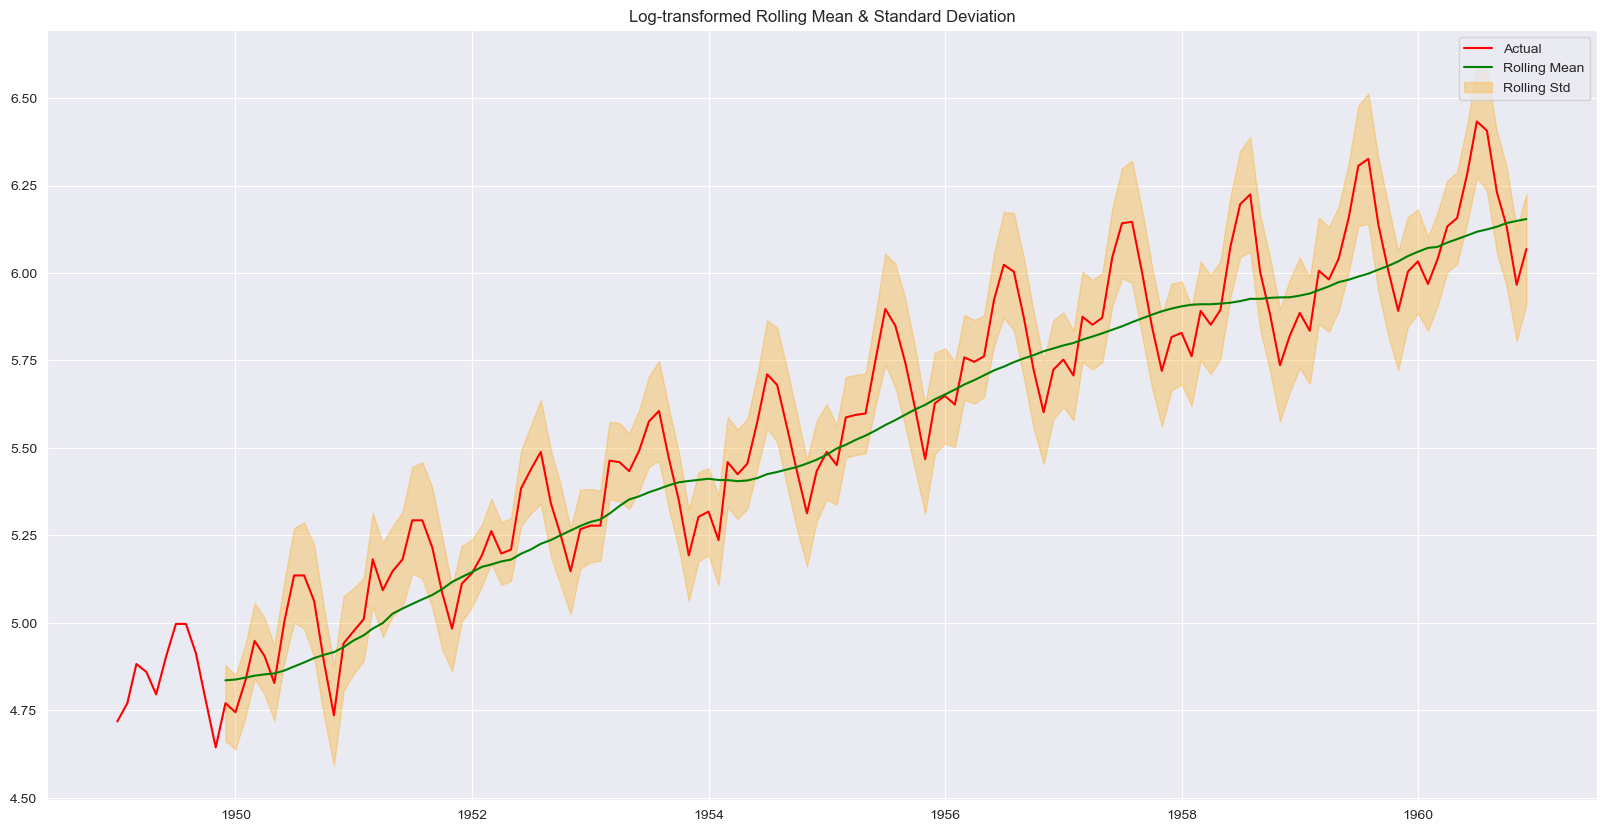

In [46]:
# take the log
ts_log = np.log(ts)
MAvg=ts_log.rolling(window=12).mean()
MStd=ts_log.rolling(window=12).std()

# plot
tslog_pass = np.array(ts_log["#Passengers"])
plt.figure(figsize=(20,10))
actual = plt.plot(ts_log, color='red', label='Actual')
mean_12 = plt.plot(MAvg, color='green', label='Rolling Mean')
std_12 = plt.fill_between(ts.index,
                          tslog_pass - np.array(MStd).reshape((144,)),
                          tslog_pass + np.array(MStd).reshape((144,)),
                          alpha = 0.3, color='orange', label='Rolling Std')
plt.legend(loc='best')
plt.title('Log-transformed Rolling Mean & Standard Deviation')
plt.show(block=False)

### Differencing Method

This did not help us to remove the non-stationarity. Therefore, we can remove the non-stationarity from the log transform of the time series using differencing method.

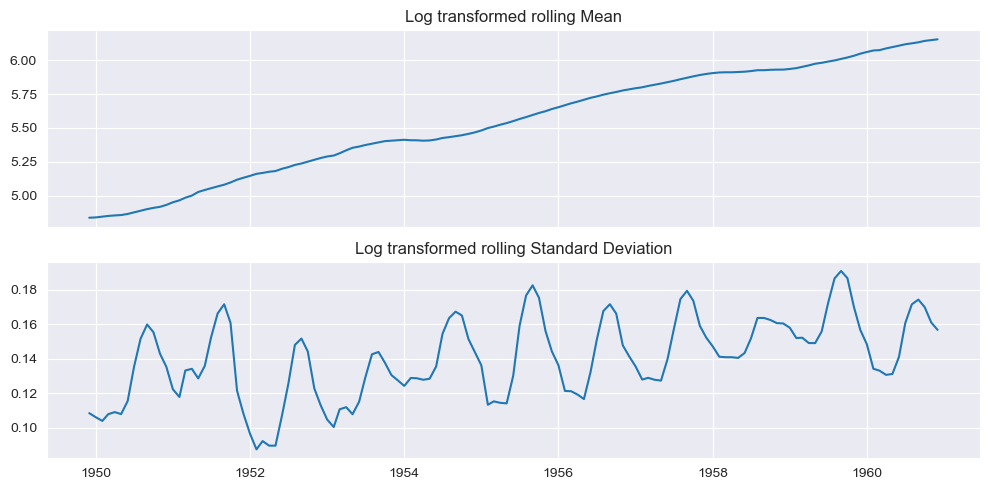

In [48]:
# visualize stationarity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5), sharex=True)
ax1.plot(MAvg)
ax1.set_title("Log transformed rolling Mean")
ax2.plot(MStd)
ax2.set_title("Log transformed rolling Standard Deviation")
plt.tight_layout()

In [49]:
# substracting the rolling average from the log transformed data
ts_log_diff=ts_log-MAvg
ts_log_diff=ts_log_diff.dropna()
ts_log_diff.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


To automate later tasks, we create the function that plots the input time series, rolling average and standard deviations over 12 months to check for the stationarity, and performs ADF test.


In [50]:
def ADF(timeseries, title):
    # plotting ts and rolling mean and std
    rolling = timeseries.rolling(window = 12)
    roll_avg = rolling.mean()
    roll_std = rolling.std()
    plt.figure(figsize  = (20,10))
    plt.plot(timeseries, label = title)
    plt.plot(roll_avg, label = 'rolling average')
    plt.plot(roll_std,label = 'rolling standard deviation')
    plt.title(title)
    plt.xlabel('Time[months]')
    plt.ylabel('Number of Passangers')
    plt.legend()
    
    # performing an ADF
    
    print(('Dickey-Fuller Test of {}:').format(title))
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    

Now we apply the function on the output of the differencing method and justify the results.

Dickey-Fuller Test of Timeseries log transformed and differention method apppied:
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Obs              119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


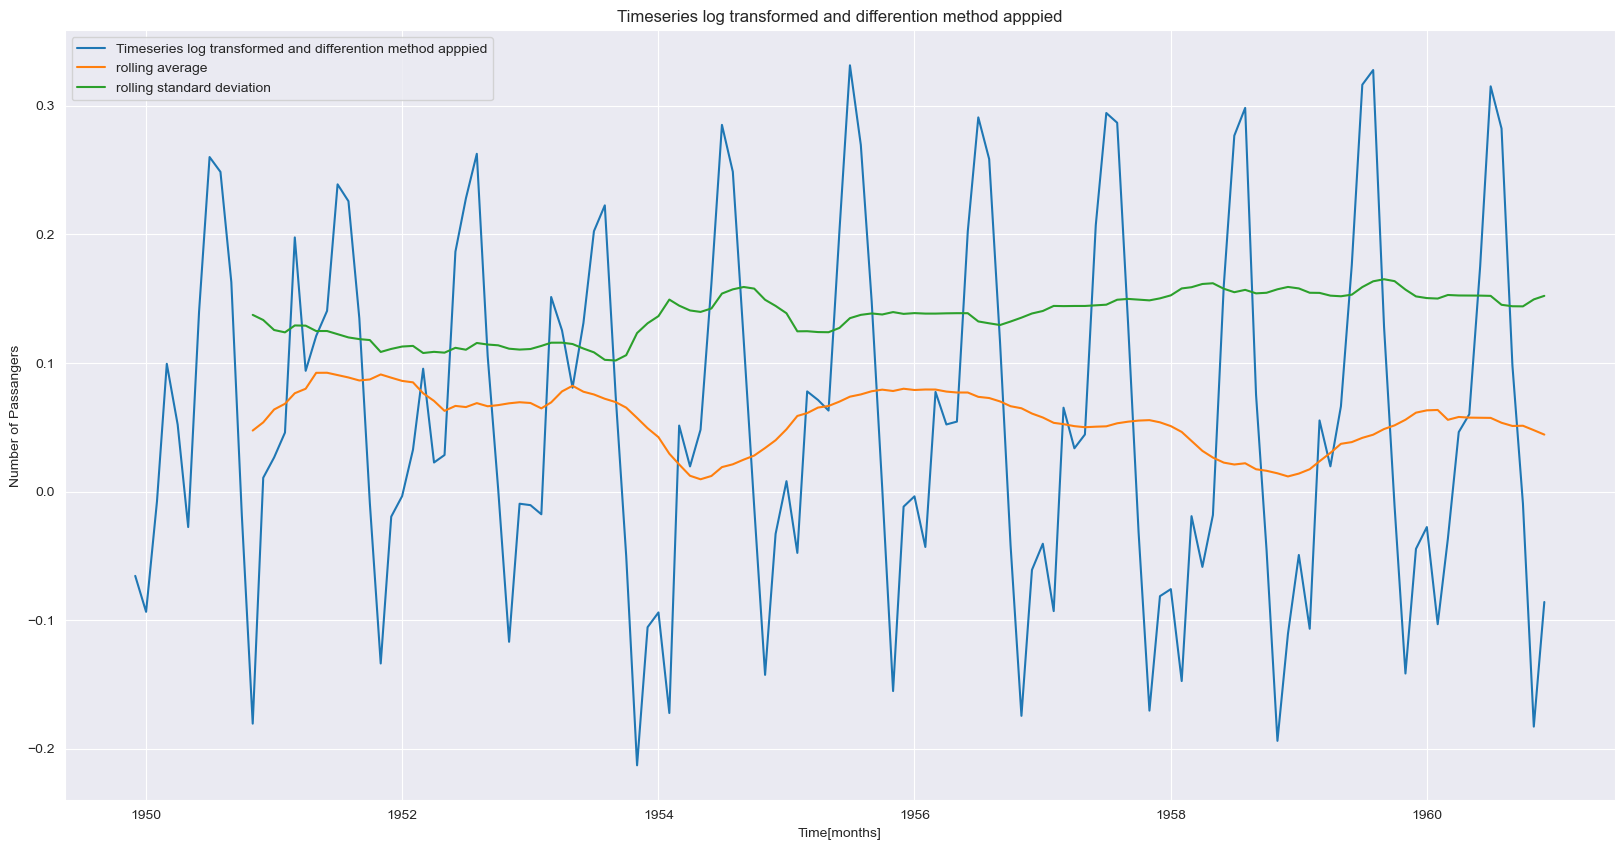

In [51]:
ADF(timeseries = ts_log_diff, title= 'Timeseries log transformed and differention method apppied')

##### Justification of results:

The p-value is below 0.05, which means that we can reject the Null Hypothesis. Therefore the timeseries is after 
log-transformation and application of the differencing method now stationary!

Let's decompose time series into its components (Trend, Seasonality and Residual). Check stationarity of the decomposed components.

Dickey-Fuller Test of Trend:
Test Statistic           -2.503535
p-value                   0.114617
Lags Used                13.000000
No. of Obs              107.000000
Critical Value (1%)      -3.492996
Critical Value (5%)      -2.888955
Critical Value (10%)     -2.581393
dtype: float64
Dickey-Fuller Test of Seasonal:
Test Statistic         -3.931107e+14
p-value                 0.000000e+00
Lags Used               1.200000e+01
No. of Obs              1.200000e+02
Critical Value (1%)    -3.486056e+00
Critical Value (5%)    -2.885943e+00
Critical Value (10%)   -2.579785e+00
dtype: float64
Dickey-Fuller Test of Residuals:
Test Statistic         -6.861120e+00
p-value                 1.601561e-09
Lags Used               9.000000e+00
No. of Obs              1.110000e+02
Critical Value (1%)    -3.490683e+00
Critical Value (5%)    -2.887952e+00
Critical Value (10%)   -2.580857e+00
dtype: float64


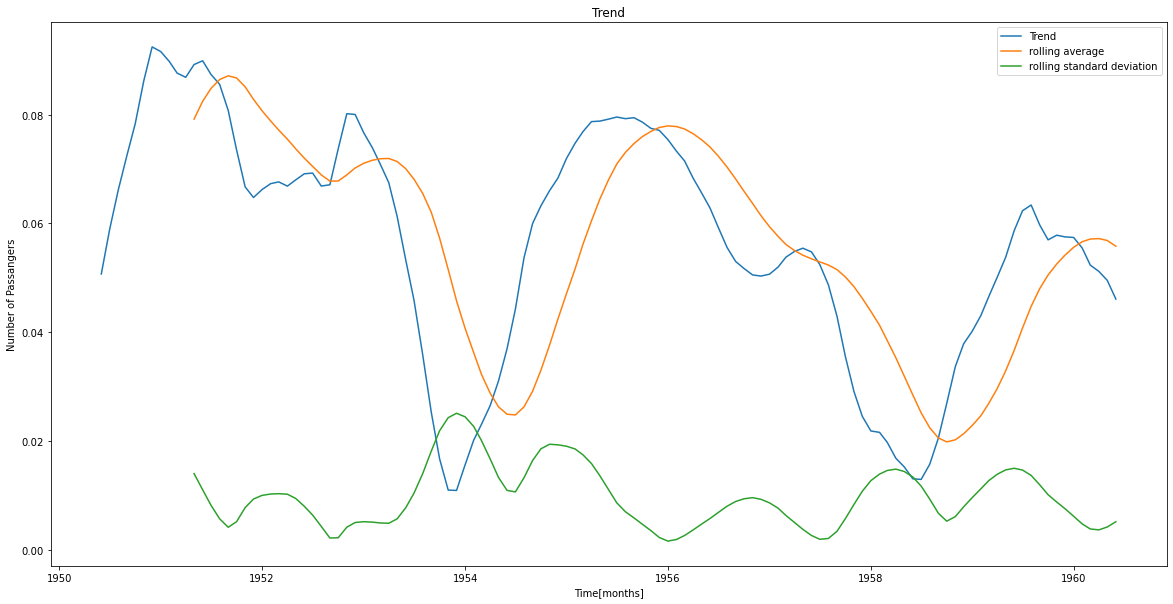

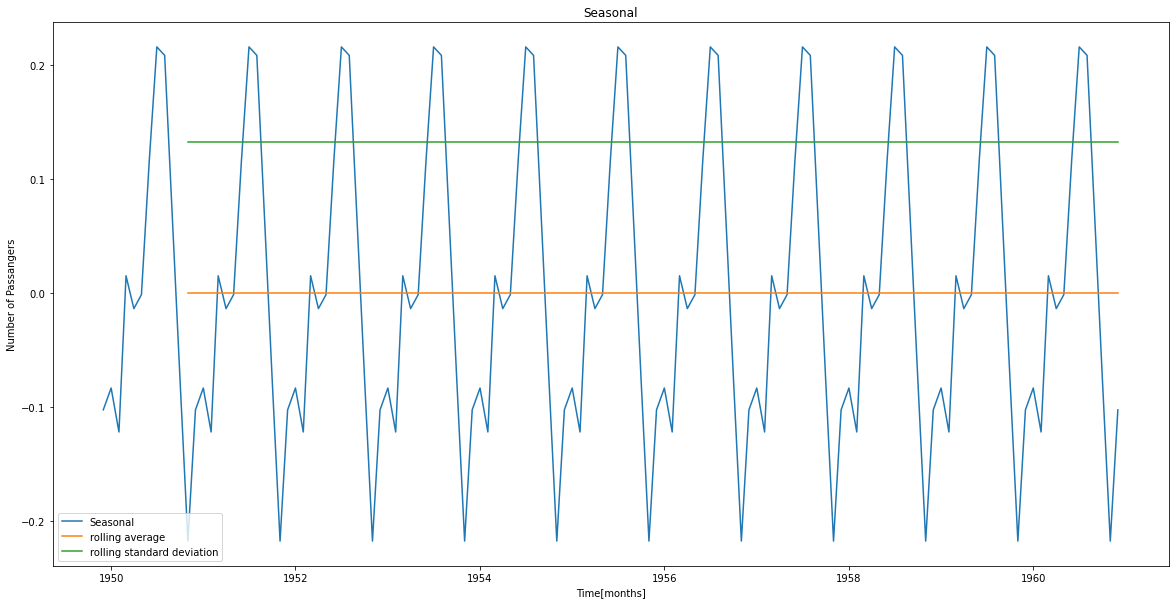

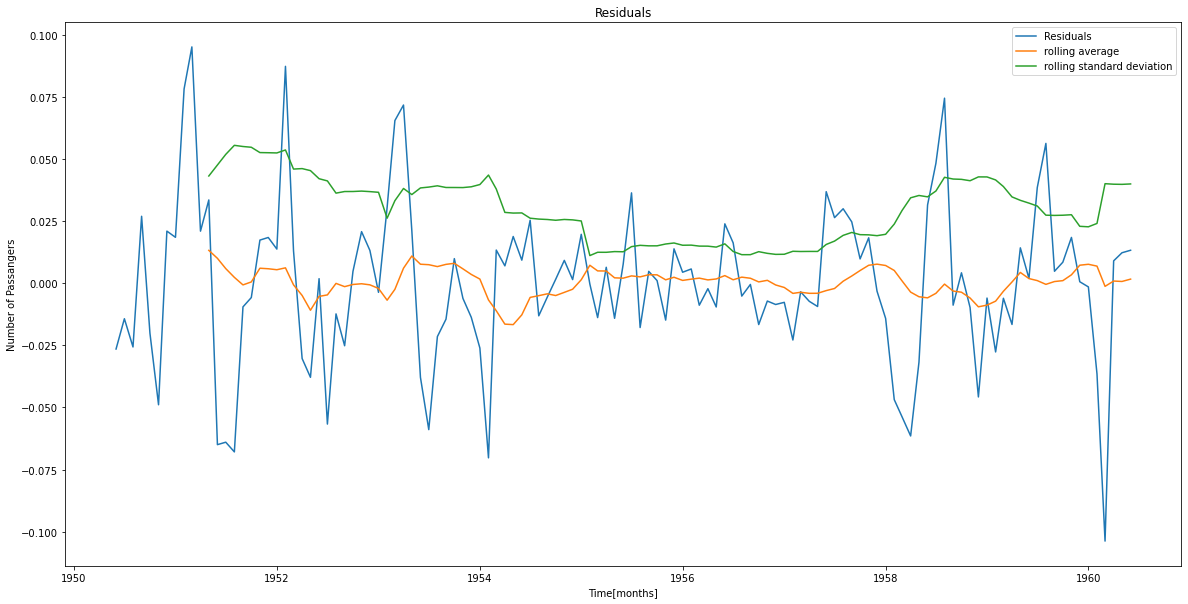

In [105]:
d = seasonal_decompose(ts_log_diff)

for series in [['Trend', d.trend], ['Seasonal', d.seasonal],['Residuals', d.resid]]:
    series[1] = series[1].dropna()
    ADF(series[1], series[0])


##### Results:

According to the p-value of the AFD test only the Trend seems to non-stationary. The decomposed seasonal and residual series are clearly stationary. These assumptions are generally supported by the plots. Only the standard dev of the residuals seems
to show kind of periodic behaviour, but it is still surveyable.

## Forecasting a Time Series

Lets make model on the TS after differencing. It is relatively easier to add noise and seasonality back into predicted residuals in this case. 

Having performed the trend and seasonality estimation techniques, there can be two situations:

- A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

- A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

#### How we can determine the p and q values?

We can do that by using the autocorrelation and partial auto correlation plots.

* Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself.

* Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

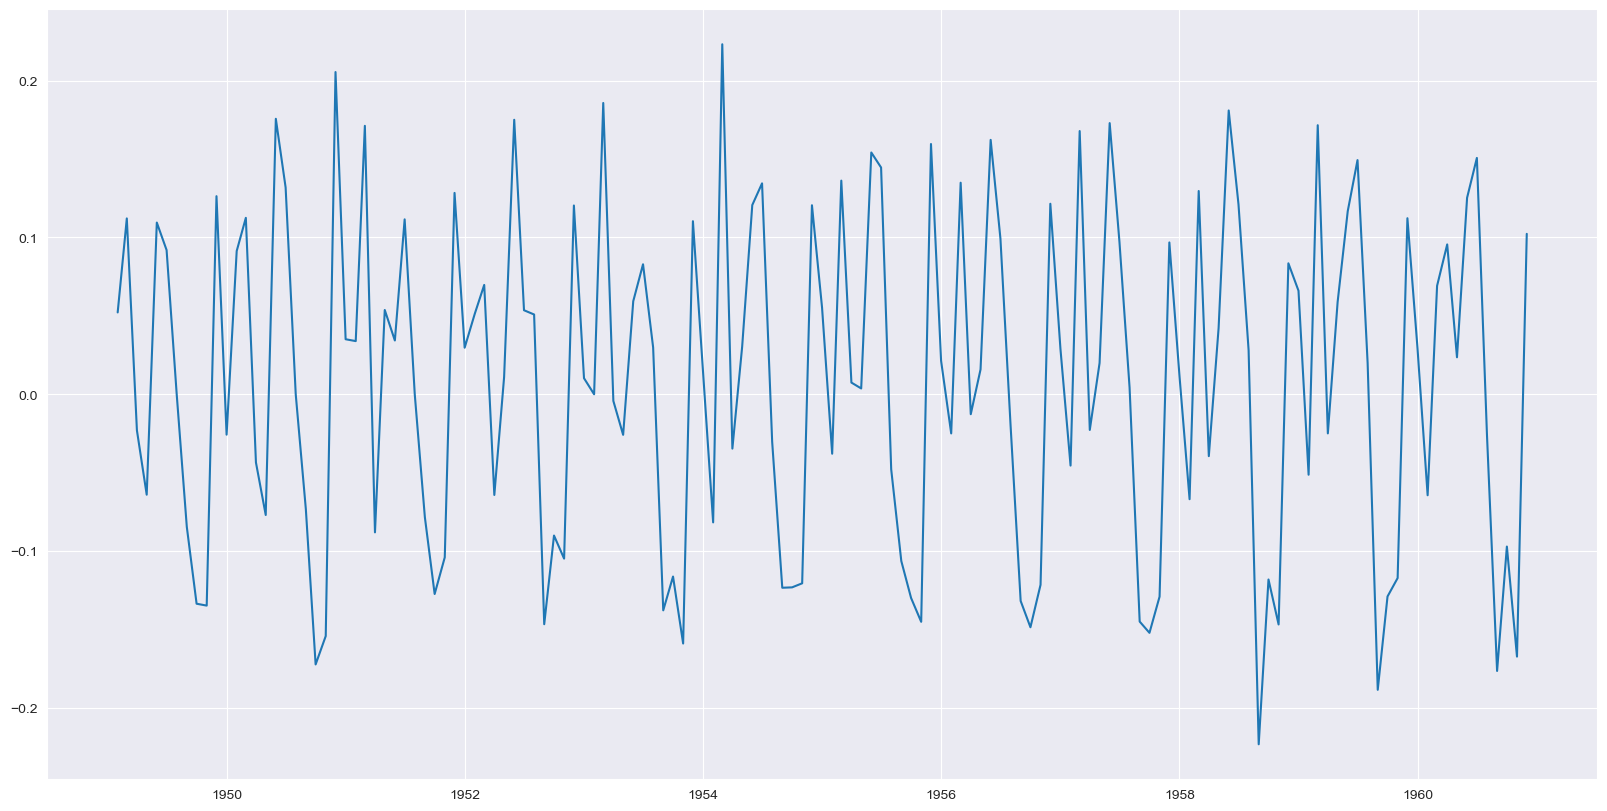

In [53]:
# shifting the data to generate lagged data
plt.figure(figsize=(20,10))
ts_shift=ts_log-ts_log.shift() # pd.DF.shift is like np.roll()
ts_shift=ts_shift.dropna()
plt.plot(ts_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

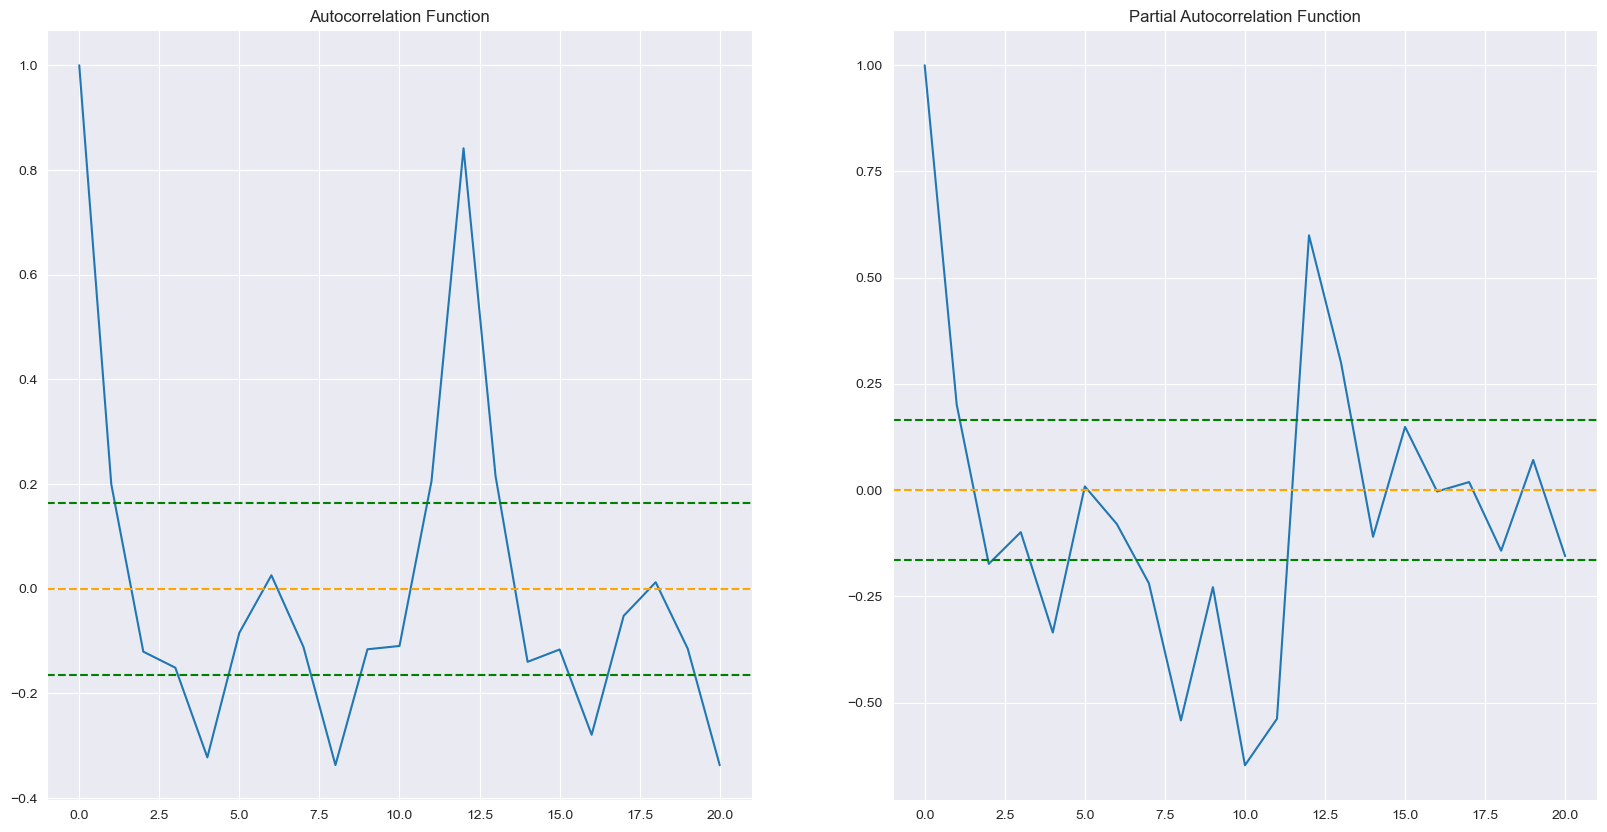

In [56]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(ts_shift, nlags=20)
lag_pacf=pacf(ts_shift, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='orange')
plt.axhline(y=-1.96/np.sqrt(len(ts_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='orange')
plt.axhline(y=-1.96/np.sqrt(len(ts_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

The green, dotted lines around 0 (orange) are the confidence intervals
To determine p and q we will use these confidence levels

* For the <b>p</b> we will use the lag value where the PACF chart crosses the upper confidence interval for the first time. (--> p = 2)
* For the <b>q</b> we will use the lag value where the ACF chart crosses the upper confidence interval for the first time (--> q = 2)



Let's make 3 different ARIMA models considering individual as well as combined effects. We print also the RSS for each. We also note that here RSS is for the values of residuals and not actual series.

Using statsmodels.tsa.arima_model import ARIMA

Now, we create an AR, an MA and a combined model and fit them to the transformed time series. Then we plot the transformed time series with the fitted values of each model. Finally, we calculate the RSS for each model. Which one is the best?




RSS of AR-model: 1.5023023282322732


C:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


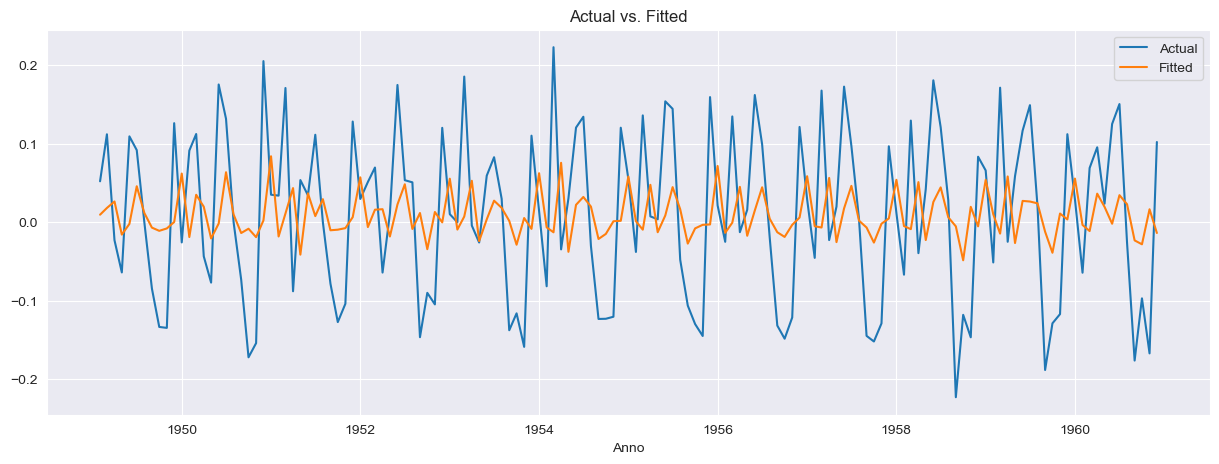

In [65]:
# AR model
# RSS as already seen in lin reg: don't forget: lower is better because we are dealing with residuals!!
# formula RSS: np.sum(np.square(predicted - true)

ar = ARIMA(endog = ts_shift, order = (2,0,0)) # how do i state that it is a AR model only?
arfit = ar.fit()
arpredict = arfit.predict()

ts_shift_ar = np.array(ts_shift)
arpredict_ar = np.array(arpredict).reshape(143,1)

ar_rss = np.sum(np.square(ts_shift_ar - arpredict_ar)) # reshape every follwing array

print('RSS of AR-model:', ar_rss)

plt.figure(figsize = (15,5))

plt.plot(ts_shift, label = 'Actual')
plt.plot(arpredict, label = 'Fitted')
    
plt.title('Actual vs. Fitted')
plt.xlabel('Anno')
plt.legend()
# ORDER is p,d,q

RSS of MA-model: 1.472140333970905


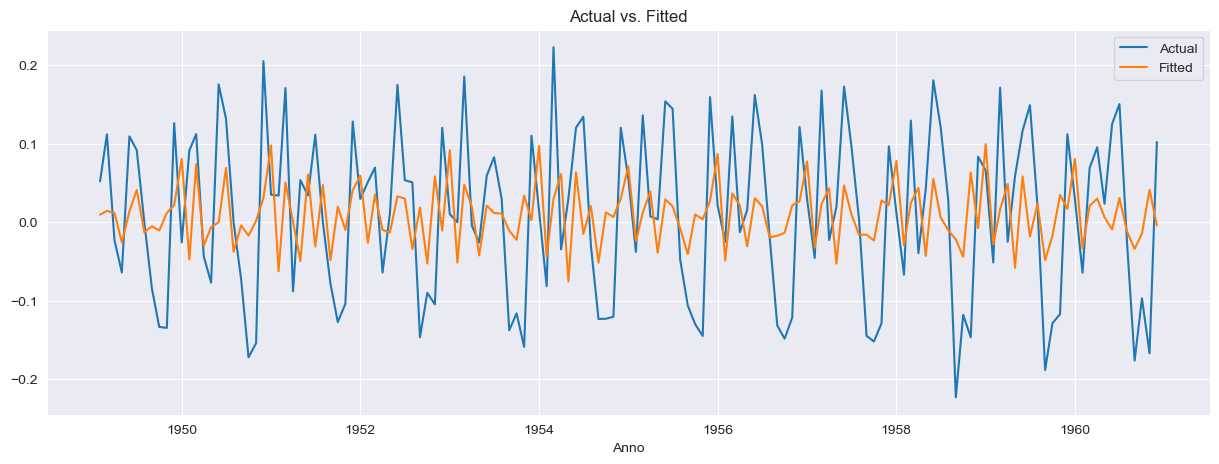

In [67]:
# MA model

ma = ARIMA(endog = ts_shift, order = (0,0,2)) # how do i state that it is a AR model only?
mafit = ma.fit()
mapredict = mafit.predict()

mapredict_ar = np.array(mapredict).reshape(143,1)

ma_rss = np.sum(np.square(ts_shift_ar - mapredict_ar))
print('RSS of MA-model:', ma_rss)

plt.figure(figsize = (15,5))

plt.plot(ts_shift, label = 'Actual')
plt.plot(mapredict, label = 'Fitted')
    
plt.title('Actual vs. Fitted')
plt.xlabel('Anno')
plt.legend()

RSS of ARMA-model: 1.2170134096406873


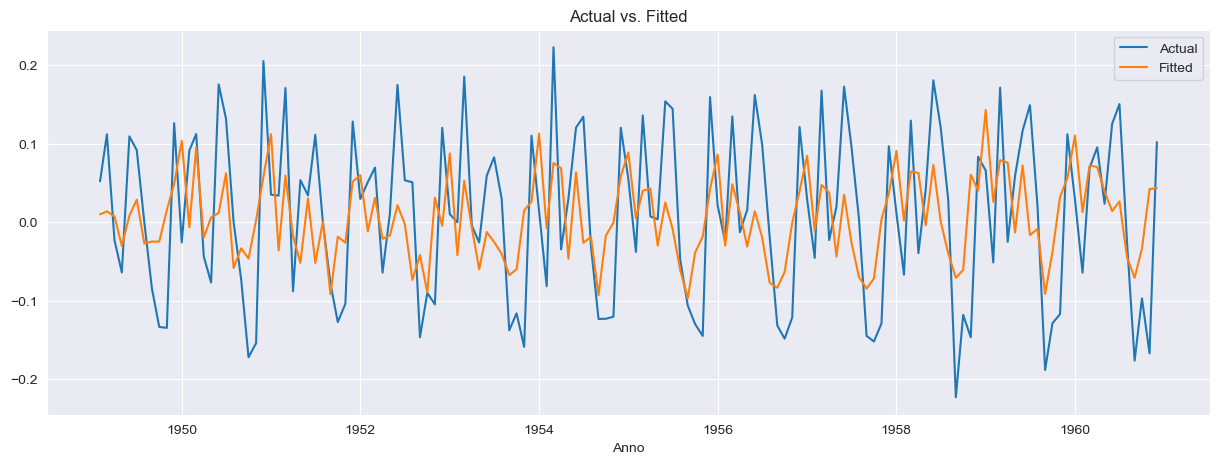

In [68]:
# combined model

arma = ARIMA(endog = ts_shift, order = (2,0,2)) # how do i state that it is a AR model only?
armafit = arma.fit()
armapredict = armafit.predict()

armapredict_ar = np.array(armapredict).reshape(143,1)

arma_rss = np.sum(np.square(ts_shift_ar - armapredict_ar))
print('RSS of ARMA-model:', arma_rss)

plt.figure(figsize = (15,5))

plt.plot(ts_shift, label = 'Actual')
plt.plot(armapredict, label = 'Fitted')
    
plt.title('Actual vs. Fitted')
plt.xlabel('Anno')
plt.legend()

Can we use the best model based on the last task to make predictions? We'll have to justify in terms of residual errors, kernel density estimation and the actual vs fitted values plots.

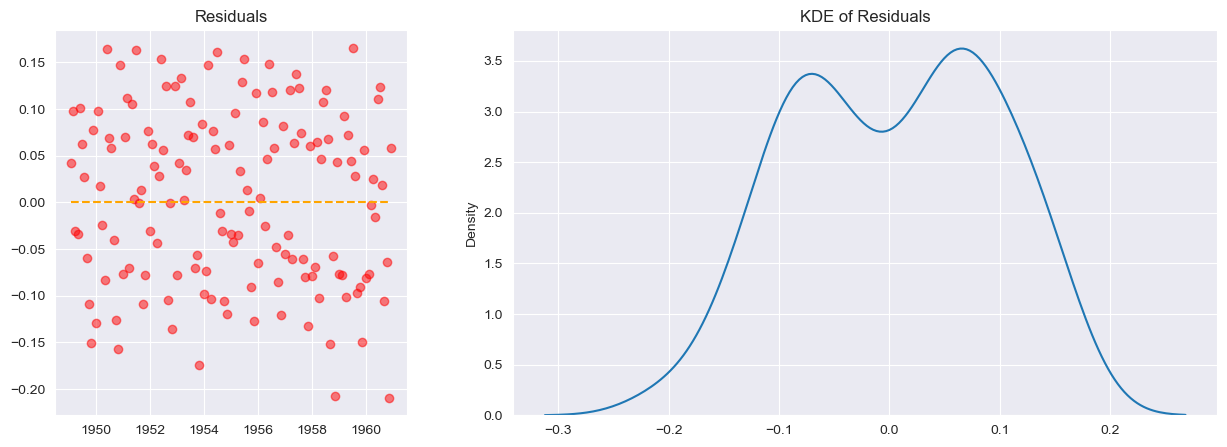

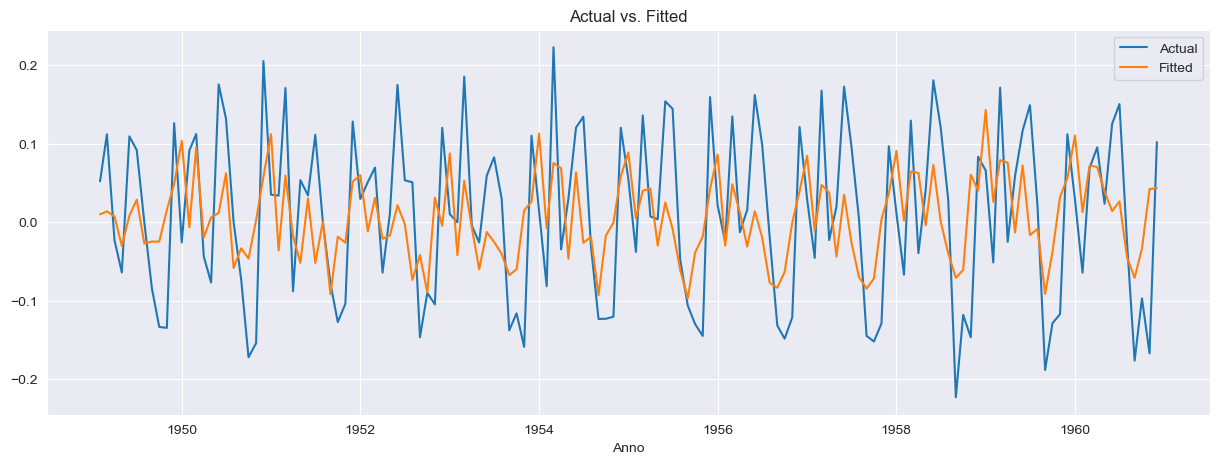

In [70]:
# Plot residual errors

x = [i for i in ts_shift.index]
# ar_resids = (ts_shift_ar - arpredict_ar)
# ma_resids = (ts_shift_ar - mapredict_ar)
arma_resids = (ts_shift_ar - armapredict_ar).reshape(143)


fig, axs = plt.subplots(1,2, figsize = (15,5), gridspec_kw={'width_ratios': [1,2]})

# axs[0].scatter(x, ar_resids, alpha = .5, color = 'blue', label = 'AR')
# axs[0].set_title('AR-Model')
# axs[1].scatter(x, ma_resids,  alpha = .5, color = 'green',label = 'MA')
# axs[1].set_title('MA-Model')
axs[0].scatter(ts_shift.index, arma_resids, alpha = .5,  color = 'red', label = 'ARMA')
#axs[0].set_title('ARMA-Model')
axs[0].set_title('Residuals')
axs[0].plot(x,np.zeros(len(ts_shift_ar)), '--', color = 'orange')

#for i in range(3):
#    axs[i].plot(x,np.zeros(len(ts_shift_ar)), '--', color = 'orange')

# Plot the KDE
sns.kdeplot(arma_resids, ax = axs[1])
axs[1].set_title('KDE of Residuals')


# Actual vs Fitted

plt.figure(figsize = (15,5))
plt.plot(ts_shift, label = 'Actual')
plt.plot(armapredict, label = 'Fitted')
    
plt.title('Actual vs. Fitted')
plt.xlabel('Anno')
plt.legend()


##### Results
The residuals look quite random and are almost normally distribututed. The Fitted Values predict the seasonality of the data pretty good as seen in the plot above.

The first step would be to store the predicted results as a separate series and observe it before forecasting.

In [71]:
results_ARIMA = armafit
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True) 
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.010049
1949-03-01    0.013803
1949-04-01    0.007457
1949-05-01   -0.030135
1949-06-01    0.008385
dtype: float64


Note that the observations start from the second month and not the first one. The reason is that we used a lag of 1 month in our model fit.

To mitigate that we can use cumulative sum at an index and add it to a base number. In this way we convert differencing to log scale and add the differences to a base number

In [72]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.010049
1949-03-01    0.023852
1949-04-01    0.031309
1949-05-01    0.001174
1949-06-01    0.009558
dtype: float64


We create a time series with all values as base number and add the differences to it

In [73]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[:,0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.780733
1949-03-01    4.906654
1949-04-01    4.891121
1949-05-01    4.796964
dtype: float64

Let s take now the exponent of the logarithmic ARIMA predictions and apply it to the original series



Is there any difference with in the RSS?

RSS after transform: 3876625.847


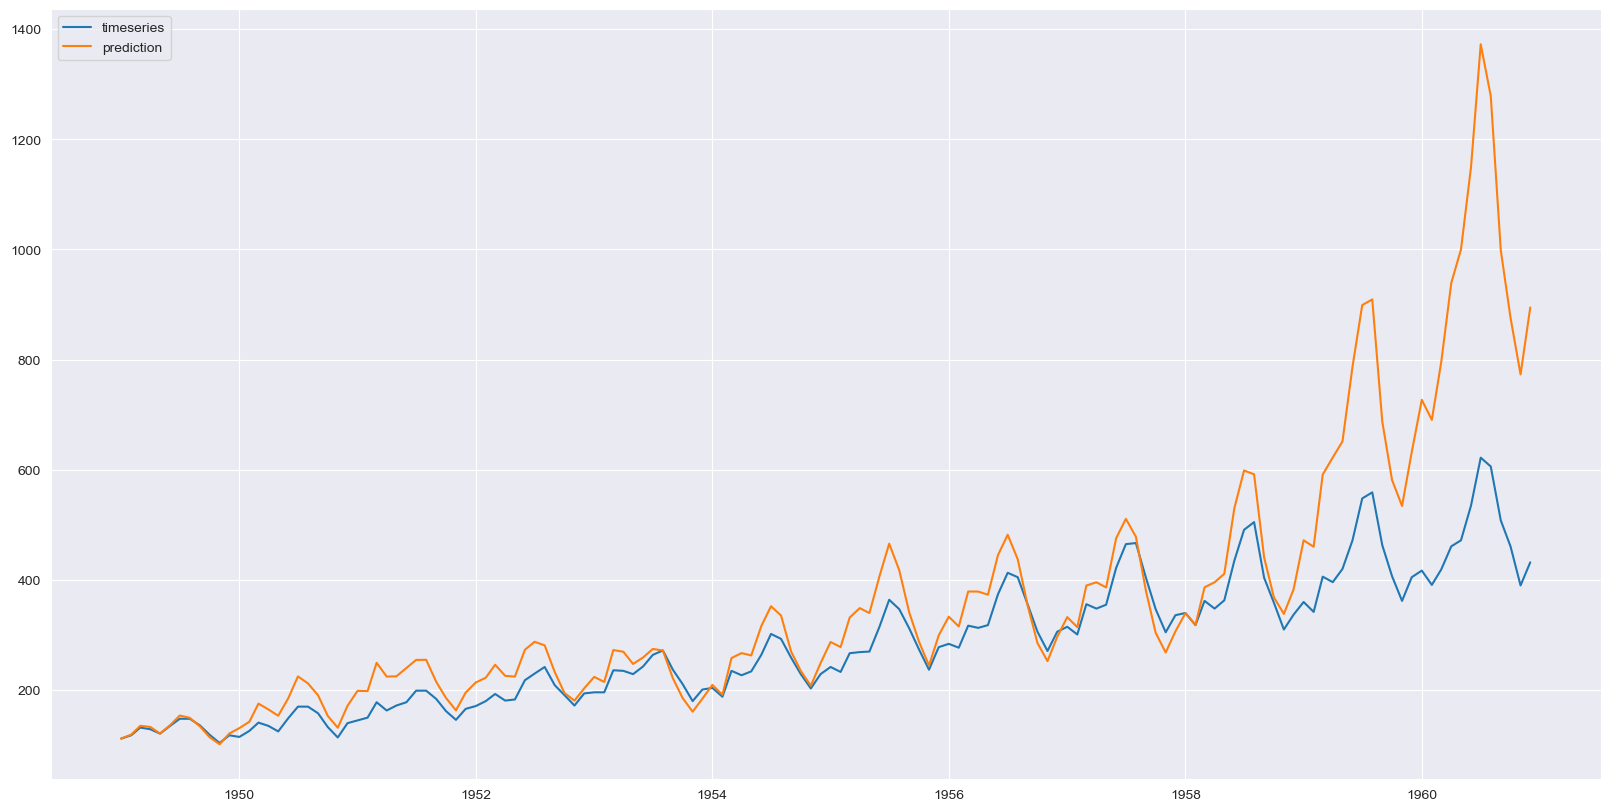

In [74]:
# calculate the exponent of ARIMA log
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,10))
plt.plot(ts,label = 'timeseries')
plt.plot(predictions_ARIMA, label = 'prediction')
plt.legend()
print('RSS after transform: %.3f' %np.sum(np.square(np.array(ts).reshape(144) - np.array(predictions_ARIMA).reshape(144))))

##### Results
The prediction predicts the seasonality of the data quite nice, but misses to predict the trend of the timeseries.
Therefore the RSS is a lot higher compared to the prediction above where the trend wasn't concerned.

### Forecasting

We forecast the time series for the next 10 years with a plot it after 95% confidence interval.

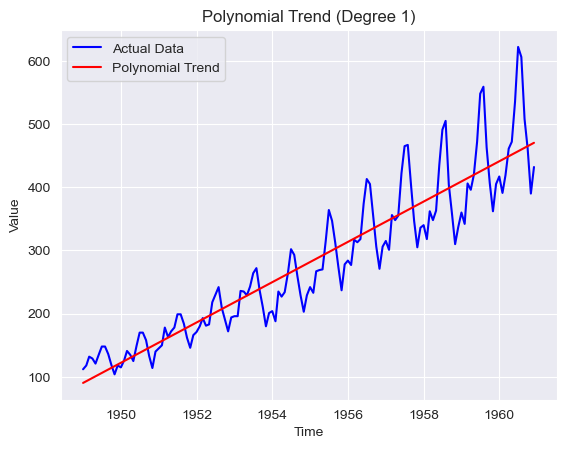

Polynomial Coefficients: [0.00000000e+00 1.01033381e-15]
Intercept: 759.9545874878297


In [97]:
# we find the polynomial fo the trend
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

time_points = np.array(ts.index)
values = np.array(ts["#Passengers"])

# PLAY WITH THIS VALUE HERE
degree = 1

# Reshape the data for scikit-learn
time_points = time_points.reshape(-1, 1)

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(time_points)

# Fit a polynomial regression model
lm = LinearRegression()
lm.fit(X_poly, values)

# Predict values using the fitted model
y_pred = lm.predict(X_poly)

# Plot the original data and the fitted polynomial trend
plt.plot(time_points, values, label='Actual Data', color='blue')
plt.plot(time_points, y_pred, label='Polynomial Trend', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Polynomial Trend (Degree {degree})')
plt.legend()
plt.show()

# Print the coefficients of the polynomial
coefficients = lm.coef_
intercept = lm.intercept_
print(f'Polynomial Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

In [102]:
# going higher than 2nd degree is not worth it
mod = sm.tsa.SARIMAX(ts, order=(2, 0, 2), trend=[759, 1, 1])
# Estimate the parameters
res = mod.fit()
# compute forecast of ten years with 95% confidence
f_cast_10y = res.get_forecast(steps = 10*12 + 1).summary_frame(alpha =0.05)
f_cast_10y.head()

#Passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-01-01,485.074262,26.709386,432.724827,537.423697
1961-02-01,528.715679,37.844960,454.540920,602.890439
1961-03-01,541.119512,40.977957,460.804192,621.434832
1961-04-01,529.925479,40.978684,449.608734,610.242223
1961-05-01,512.970037,41.989133,430.672848,595.267226


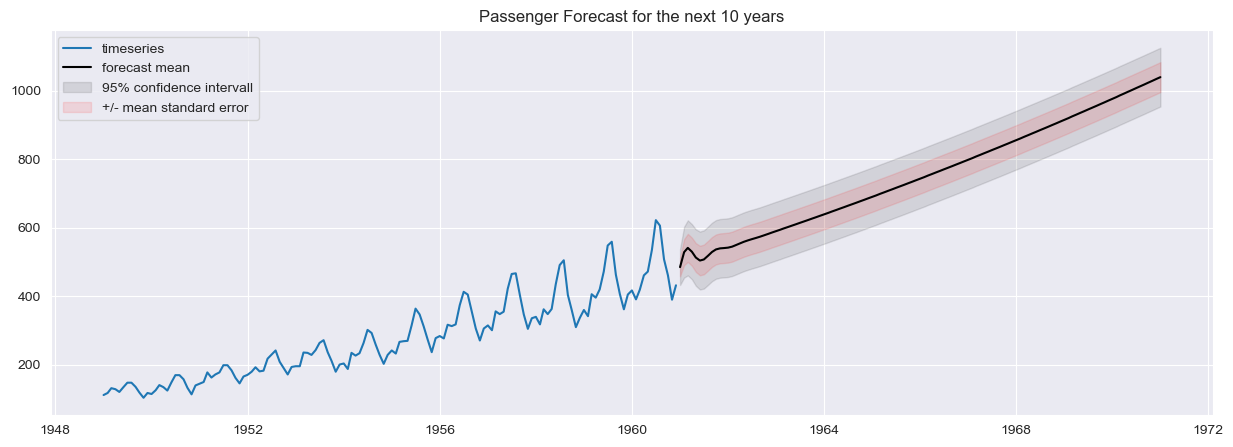

In [103]:
# plot the forecast

fig, ax = plt.subplots(figsize = (15,5))

ax.plot(ts,label = 'timeseries')
ax.plot(f_cast_10y['mean'], color = 'k', label = 'forecast mean')
ax.fill_between(f_cast_10y.index, f_cast_10y['mean_ci_lower'], f_cast_10y['mean_ci_upper'], color='k', alpha=0.1,
               label = '95% confidence intervall')
ax.fill_between(f_cast_10y.index, f_cast_10y['mean'] - f_cast_10y['mean_se'], f_cast_10y['mean'] + f_cast_10y['mean_se'],
               color = 'red', alpha = 0.1, label = '+/- mean standard error')
ax.set_title('Passenger Forecast for the next 10 years')
ax.legend()

In [118]:
# idea for next time forecasting: take arma.fit().fittedvalues make forecast from that on.